# Interactive Nerve Fiber Activation Profiles

This notebook allows interactive exploration of nerve fiber activation profiles under varying contact current conditions.

It implements the project goal:
- Fix the current on contact 1 at 400 μA
- Vary the current on contact 2 in increments (0%, 20%, 40%, 60%, 80%, 100% of 400 μA)
- Visualize activation profiles (red for activated fibers, grey for non-activated)

In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import imageio
import pandas as pd
from IPython.display import display, Image, HTML
import plotly.express as px
# Import the setup function from notebook_setup.py
from notebook_setup import setup_notebook

# Call the setup function
setup_notebook()
# Add the repository root to the path if necessary
try:
    from src.core.plotter import activation_profile
    from src.core.query import Query
    from src.utils.enums import Object  # Import Object enum
except ImportError:
    print("Make sure to run setup_notebook() is configured correctly")


Working directory set to: c:\Users\RXCHC\OneDrive\Documents\GitHub\ascent
'ascent' folder added to sys.path: c:\Users\RXCHC\OneDrive\Documents\GitHub\ascent
pygame 2.5.2 (SDL 2.28.3, Python 3.10.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Define the Conditions

We'll define the different stimulation conditions based on the project plan.

In [4]:
# Define the conditions from the project plan
BASE_CURRENT_UA = 335

CONDITIONS = [
    {"p_percent": 0, "sim_array": [1.0, 0.0, 0.0, 0.0, 0.0, 0.0], "I_total_uA": BASE_CURRENT_UA * (1 + 0/100)},
    {"p_percent": 20, "sim_array": [0.8333, 0.1667, 0.0, 0.0, 0.0, 0.0], "I_total_uA": BASE_CURRENT_UA * (1 + 20/100)},
    {"p_percent": 40, "sim_array": [0.7143, 0.2857, 0.0, 0.0, 0.0, 0.0], "I_total_uA": BASE_CURRENT_UA * (1 + 40/100)},
    {"p_percent": 60, "sim_array": [0.625, 0.375, 0.0, 0.0, 0.0, 0.0], "I_total_uA": BASE_CURRENT_UA * (1 + 60/100)},
    {"p_percent": 80, "sim_array": [0.5556, 0.4444, 0.0, 0.0, 0.0, 0.0], "I_total_uA": BASE_CURRENT_UA * (1 + 80/100)},
    {"p_percent": 100, "sim_array": [0.5, 0.5, 0.0, 0.0, 0.0, 0.0], "I_total_uA": BASE_CURRENT_UA * (1 + 100/100)}
]

In [6]:
# Verification Cell - Confirm Percentage Assignment & Current Calculations

print("Verification of Conditions Matrix Calculations\n")
print(f"{'Step':^5} | {'p_percent':^10} | {'Total (μA)':^12} | {'Sim Array[0]':^14} | {'Sim Array[1]':^14} | {'Calculated Contact 1':^20} | {'Calculated Contact 2':^20}")
print("-" * 110)

BASE_CURRENT_UA = 335  # Fixed current on contact 1

for i, condition in enumerate(CONDITIONS):
    # Extract values from condition
    p_percent = condition["p_percent"]
    total = condition["I_total_uA"]
    sim0 = condition["sim_array"][0]
    sim1 = condition["sim_array"][1]
    
    # Calculate contact currents based on the simulation array proportions
    contact1 = total * sim0
    contact2 = total * sim1
    
    # Alternative calculation based on p_percent and fixed Contact 1 current
    expected_contact1 = BASE_CURRENT_UA
    expected_contact2 = BASE_CURRENT_UA * (p_percent/100)
    expected_total = expected_contact1 + expected_contact2
    
    # Print verification
    print(f"{i+1:^5} | {p_percent:^10.2f} | {total:^12.2f} | {sim0:^14.4f} | {sim1:^14.4f} | {contact1:^20.2f} | {contact2:^20.2f}")
    
    # Check for any inconsistencies
    if abs(contact1 - expected_contact1) > 0.01:
        print(f"  ⚠️ Contact 1 inconsistency at step {i+1}: {contact1:.2f} vs expected {expected_contact1:.2f}")
    if abs(contact2 - expected_contact2) > 0.01:
        print(f"  ⚠️ Contact 2 inconsistency at step {i+1}: {contact2:.2f} vs expected {expected_contact2:.2f}")
    if abs(total - expected_total) > 0.01:
        print(f"  ⚠️ Total current inconsistency at step {i+1}: {total:.2f} vs expected {expected_total:.2f}")

print("\nVerification Summary:")
print(f"- Base current (Contact 1): {BASE_CURRENT_UA} μA")
print(f"- p_percent represents: (Contact 2 current / Contact 1 current) * 100")
print(f"- Total current = Contact 1 current + Contact 2 current")
print(f"- sim_array values represent proportion of each contact's current to the total")

Verification of Conditions Matrix Calculations

Step  | p_percent  |  Total (μA)  |  Sim Array[0]  |  Sim Array[1]  | Calculated Contact 1 | Calculated Contact 2
--------------------------------------------------------------------------------------------------------------
  1   |    0.00    |    335.00    |     1.0000     |     0.0000     |        335.00        |         0.00        
  2   |   20.00    |    402.00    |     0.8333     |     0.1667     |        334.99        |        67.01        
  ⚠️ Contact 1 inconsistency at step 2: 334.99 vs expected 335.00
  ⚠️ Contact 2 inconsistency at step 2: 67.01 vs expected 67.00
  3   |   40.00    |    469.00    |     0.7143     |     0.2857     |        335.01        |        133.99       
  4   |   60.00    |    536.00    |     0.6250     |     0.3750     |        335.00        |        201.00       
  5   |   80.00    |    603.00    |     0.5556     |     0.4444     |        335.03        |        267.97       
  ⚠️ Contact 1 inconsistenc

## Define the active_srcs matrix

In [ ]:
"active_srcs": {
    "ImThera_flip.json": [
    [-1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
    [-0.9690, -0.0310, 0.0000, 0.0000, 0.0000, 0.0000],
    [-0.9399, -0.0601, 0.0000, 0.0000, 0.0000, 0.0000],
    [-0.9124, -0.0876, 0.0000, 0.0000, 0.0000, 0.0000],
    [-0.8866, -0.1134, 0.0000, 0.0000, 0.0000, 0.0000],
    [-0.8621, -0.1379, 0.0000, 0.0000, 0.0000, 0.0000],
    [-0.8390, -0.1610, 0.0000, 0.0000, 0.0000, 0.0000],
    [-0.8170, -0.1830, 0.0000, 0.0000, 0.0000, 0.0000],
    [-0.7962, -0.2038, 0.0000, 0.0000, 0.0000, 0.0000],
    [-0.7765, -0.2235, 0.0000, 0.0000, 0.0000, 0.0000]],
    "cuff_index": 0 
  },

## Load the Data from Ascent

We'll use the Query class to load the sample and threshold data.

In [4]:
# Initialize and run Query to get threshold data
q = Query({
    'partial_matches': True,
    'include_downstream': True,
    'indices': {'sample': [2], 'model': [0], 'sim': [8]},
    'model_filters': [lambda m: isinstance(m.get('cuff'), dict)]  # Only use dict-type cuffs
}).run()

# Get threshold data
threshold_data = q.threshold_data(ignore_missing=True)

# Get sample and simulation objects for plotting
sample_index = 2
model_index = 0
sim_index = 8

sample_object = q.get_object(Object.SAMPLE, [sample_index])
sim_object = q.get_object(Object.SIMULATION, [sample_index, model_index, sim_index])

## Explore the Raw Threshold Data

Let's first look at the threshold data to understand what we're working with.

In [5]:
# Show the first few rows of the threshold data
print(f"Threshold data shape: {threshold_data.shape}")
threshold_data.head()

Threshold data shape: (3531, 12)


,sample,model,sim,nsim,inner,fiber,index,fiberset_index,waveform_index,active_src_index,active_rec_index,threshold
0,2,0,8,0,0,0,0,0,0,0,[0],0.398652
1,2,0,8,0,0,1,1,0,0,0,[0],0.404453
2,2,0,8,0,0,2,2,0,0,0,[0],0.414121
3,2,0,8,0,0,3,3,0,0,0,[0],0.398652
4,2,0,8,0,0,4,4,0,0,0,[0],0.410254


In [6]:
# Get some basic statistics about the thresholds
threshold_data['threshold'].describe()

count    3531.000000
mean        0.389754
std         0.021102
min         0.329043
25%         0.382217
50%         0.396719
75%         0.404453
max         0.421855
Name: threshold, dtype: float64

In [7]:
# Visualize the distribution of thresholds

fig = px.histogram(threshold_data, x='threshold', nbins=20, title='Distribution of Activation Thresholds')
fig.update_layout(
    xaxis_title='Threshold (mA)',
    yaxis_title='Count',
    bargap=0.1
)
fig.show()

## Function to Analyze Activation Profiles

This function will analyze the activation status for each condition and provide detailed information about which fibers are activated.

In [8]:
def analyze_activation_profile(condition, threshold_df, sample_obj, sim_obj, BASE_CURRENT_UA):
    """
    Analyze the activation profile for a specific condition
    
    Parameters:
    condition (dict): Condition dictionary with p_percent, sim_array, and I_total_uA
    threshold_df (pd.DataFrame): Threshold data
    sample_obj: Sample object
    sim_obj: Simulation object
    
    Returns:
    tuple: (fig, ax, plotter, activation_df, inner_stats)
    """
    p_percent = condition["p_percent"]
    sim_array = condition["sim_array"]
    I_total = condition["I_total_uA"]
    
    # Calculate contact currents based on percentages
    contact1_uA = BASE_CURRENT_UA  # Fixed current on contact 1
    contact2_uA = (p_percent / 100) * BASE_CURRENT_UA  # Variable current on contact 2
    
    print(f"\n{'='*40}")
    print(f"Analyzing condition: {p_percent}%")
    print(f"  Contact 1: {contact1_uA} μA")
    print(f"  Contact 2: {contact2_uA} μA")
    print(f"  Total Current: {I_total} μA")
    print(f"{'='*40}")
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Get nsim=0 data for each condition
    nsim_data = threshold_df[threshold_df['nsim'] == 0]
    
    # Use the activation_profile plotter
    # Pass sample_object and sim_object explicitly to ensure proper fiber positioning
    plotter = activation_profile(
        data=nsim_data,
        ax=ax,
        currents={'contact1_uA': contact1_uA, 'contact2_uA': contact2_uA},
        cutoff_current=I_total,
        cuff_array=sim_array,
        contact_colors=["red", "blue"],  # Red for contact 1, blue for contact 2
        sample_object=sample_obj,  # Pass the sample object explicitly
        sim_object=sim_obj,        # Pass the simulation object explicitly
        _return_plotter=True       # Special flag to return the plotter object too
    )
    
    # Get activation data
    activation_df = plotter.activation_df
    
    # Calculate inner statistics
    if 'inner' in activation_df.columns:
        inner_stats = activation_df.groupby('inner').agg({
            'is_activated': ['count', 'sum', lambda x: 100 * sum(x) / len(x)]
        })
        inner_stats.columns = ['Total Fibers', 'Activated Fibers', 'Activation %']
    else:
        inner_stats = None
    
    # Print summary
    activated_count = activation_df['is_activated'].sum()
    total_count = len(activation_df)
    print(f"Activation Summary: {activated_count}/{total_count} fibers activated ({100.0*activated_count/total_count:.1f}%)")
    
    return fig, ax, plotter, activation_df, inner_stats

## Generate Visualizations for Each Condition

Now let's analyze each condition and store the results for interactive exploration.


Analyzing condition: 0%
  Contact 1: 335 μA
  Contact 2: 0.0 μA
  Total Current: 335.0 μA
Fiber Activation Analysis - Cutoff Current: 335.0 μA (0.335 mA)
--------------------------------------------------------------------------------
Activation Summary: 0/321 fibers activated (0.0%)
Activation Summary: 0/321 fibers activated (0.0%)


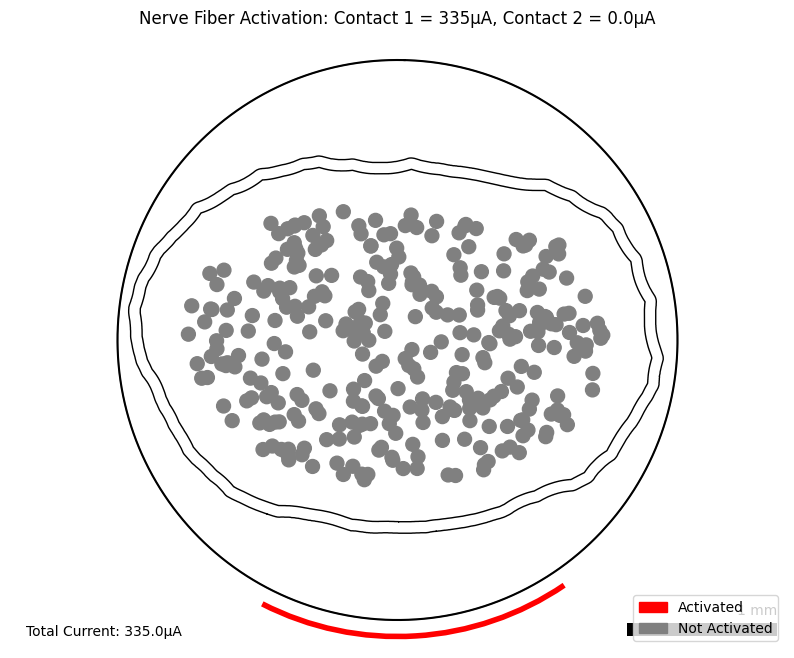


Analyzing condition: 20%
  Contact 1: 335 μA
  Contact 2: 67.0 μA
  Total Current: 402.0 μA
Fiber Activation Analysis - Cutoff Current: 402.0 μA (0.402 mA)
--------------------------------------------------------------------------------
Activation Summary: 25/321 fibers activated (7.8%)
Activation Summary: 25/321 fibers activated (7.8%)


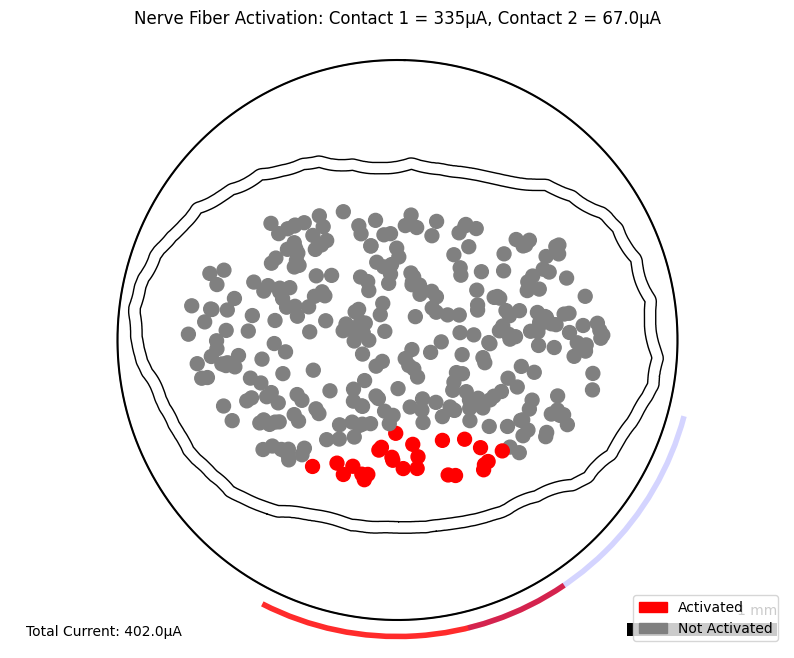


Analyzing condition: 40%
  Contact 1: 335 μA
  Contact 2: 134.0 μA
  Total Current: 468.99999999999994 μA
Fiber Activation Analysis - Cutoff Current: 468.99999999999994 μA (0.4689999999999999 mA)
--------------------------------------------------------------------------------
Activation Summary: 321/321 fibers activated (100.0%)
Activation Summary: 321/321 fibers activated (100.0%)


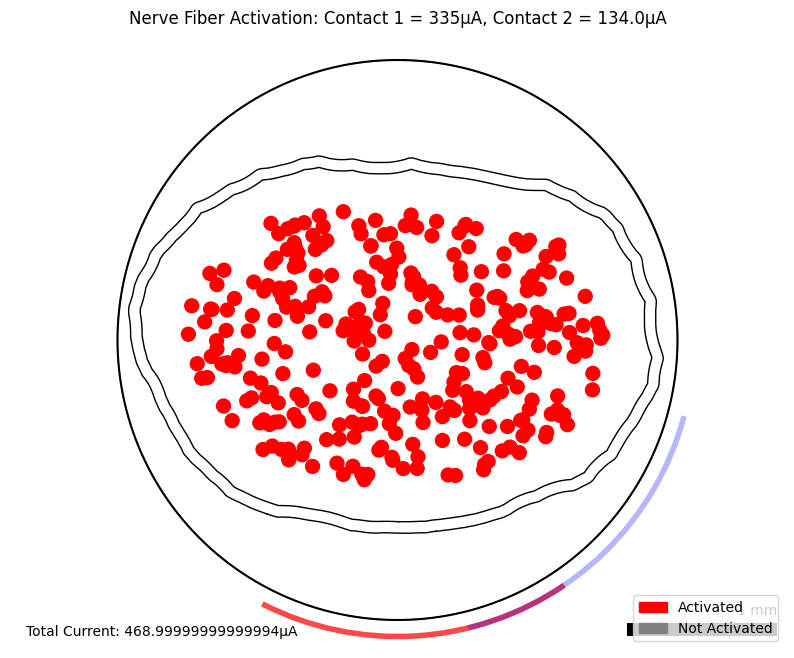


Analyzing condition: 60%
  Contact 1: 335 μA
  Contact 2: 201.0 μA
  Total Current: 536.0 μA
Fiber Activation Analysis - Cutoff Current: 536.0 μA (0.536 mA)
--------------------------------------------------------------------------------
Activation Summary: 321/321 fibers activated (100.0%)
Activation Summary: 321/321 fibers activated (100.0%)


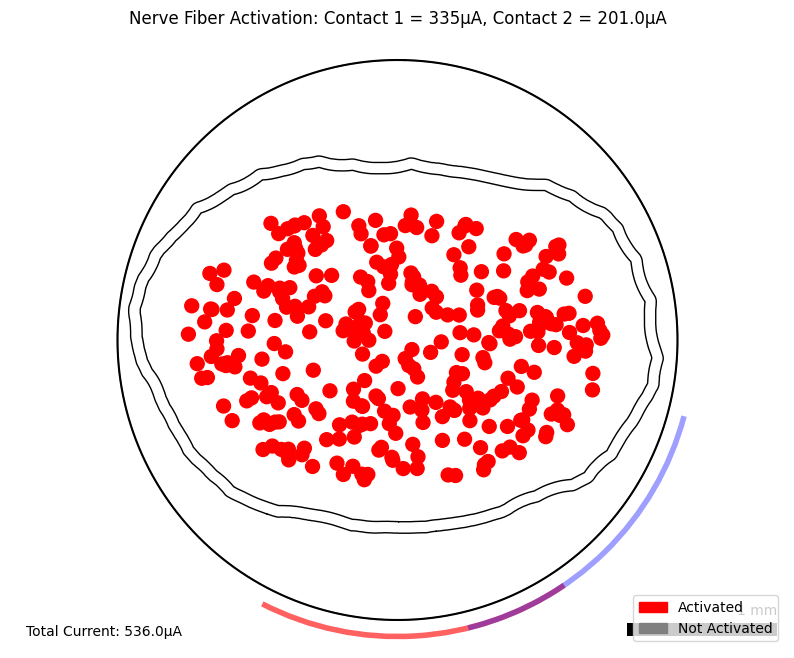


Analyzing condition: 80%
  Contact 1: 335 μA
  Contact 2: 268.0 μA
  Total Current: 603.0 μA
Fiber Activation Analysis - Cutoff Current: 603.0 μA (0.603 mA)
--------------------------------------------------------------------------------
Activation Summary: 321/321 fibers activated (100.0%)
Activation Summary: 321/321 fibers activated (100.0%)


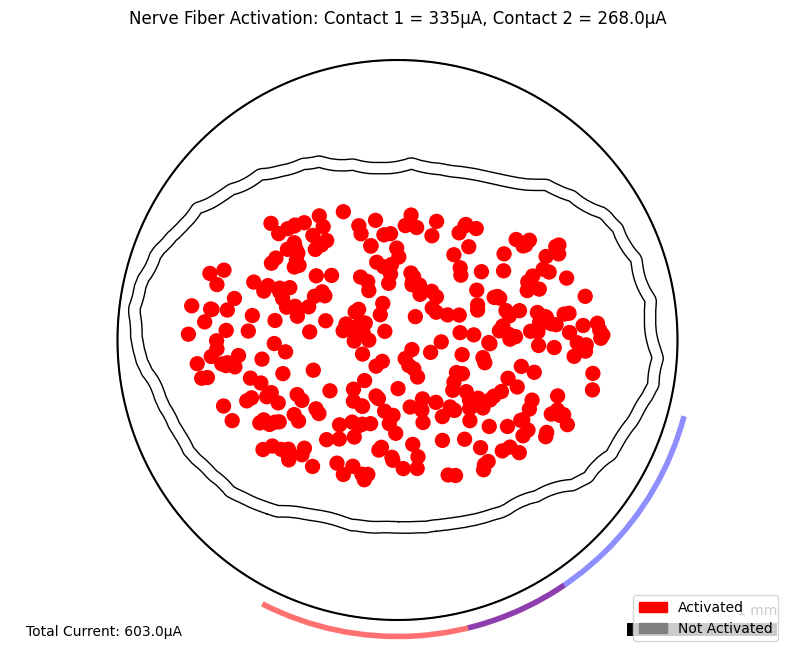


Analyzing condition: 100%
  Contact 1: 335 μA
  Contact 2: 335.0 μA
  Total Current: 670.0 μA
Fiber Activation Analysis - Cutoff Current: 670.0 μA (0.67 mA)
--------------------------------------------------------------------------------
Activation Summary: 321/321 fibers activated (100.0%)
Activation Summary: 321/321 fibers activated (100.0%)


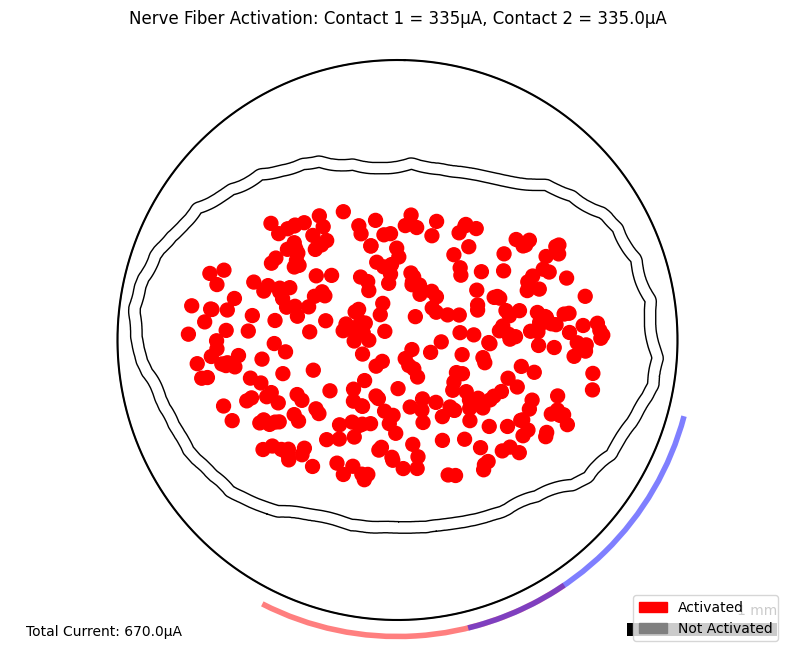

In [9]:
# Create output directory
save_directory = os.path.join('out', 'activation_profiles')
os.makedirs(save_directory, exist_ok=True)

# Store the results for each condition
results = {}
image_paths = []

# Analyze each condition
for condition in CONDITIONS:
    p_percent = condition["p_percent"]
    
    # Analyze the activation profile
    fig, ax, plotter, activation_df, inner_stats = analyze_activation_profile(
        condition, threshold_data, sample_object, sim_object, BASE_CURRENT_UA
    )
    
    # Store the results
    results[p_percent] = {
        'fig': fig,
        'ax': ax,
        'plotter': plotter,
        'activation_df': activation_df,
        'inner_stats': inner_stats,
        'condition': condition
    }
    
    # Save the figure
    output_path = os.path.join(save_directory, f'activation_profile_p{p_percent}.png')
    fig.savefig(output_path, dpi=400, bbox_inches='tight')
    image_paths.append(output_path)
    
    # Display the image in the notebook
    display(fig)
    plt.close(fig)

## Interactive Exploration of the Data

Now let's create some functions to interactively explore the data.

In [10]:
def print_activation_details(p_percent):
    """
    Print detailed activation information for a specific condition
    
    Parameters:
    p_percent (int): The percentage of Contact 2 current
    """
    if p_percent not in results:
        print(f"No data for p={p_percent}%")
        return
    
    data = results[p_percent]
    df = data['activation_df']
    condition = data['condition']
    inner_stats = data['inner_stats']
    
    # Add condition information
    contact1_uA = 400  # Fixed
    contact2_uA = (p_percent / 100) * 400
    total_current_uA = condition["I_total_uA"]
    total_current_mA = total_current_uA / 1000.0
    
    print(f"\nDetailed Fiber Activation Table for Condition: p={p_percent}%")
    print(f"Contact 1: {contact1_uA} μA, Contact 2: {contact2_uA} μA, Total: {total_current_uA} μA ({total_current_mA} mA)")
    print("-" * 100)
    
    # Print detailed info for first 10 fibers
    print("Sample of fiber activation data (first 10 fibers):")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 150)
    display(df.head(10))
    print()
    
    # Print activation statistics per inner fascicle
    if inner_stats is not None:
        print("\nActivation Statistics by Inner Fascicle:")
        display(inner_stats)
        print()
        
    # Activation threshold distribution
    print("\nActivation Threshold Distribution:")
    thresh_bins = [0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43]
    thresh_counts = []
    for i in range(len(thresh_bins)-1):
        count = ((df['threshold_mA'] >= thresh_bins[i]) & 
                 (df['threshold_mA'] < thresh_bins[i+1])).sum()
        thresh_counts.append(count)
    
    for i in range(len(thresh_bins)-1):
        print(f"  {thresh_bins[i]:.2f} - {thresh_bins[i+1]:.2f} mA: {thresh_counts[i]} fibers")
    
    # Visualize the threshold distribution
    plt.figure(figsize=(12, 5))
    
    # Bar chart of threshold counts
    plt.subplot(1, 2, 1)
    bin_labels = [f"{thresh_bins[i]:.2f}-{thresh_bins[i+1]:.2f}" for i in range(len(thresh_bins)-1)]
    plt.bar(bin_labels, thresh_counts)
    plt.title(f"Threshold Distribution (p={p_percent}%)")
    plt.ylabel("Number of Fibers")
    plt.xlabel("Threshold Range (mA)")
    plt.xticks(rotation=45)
    
    # Pie chart of activated vs non-activated
    activated = df['is_activated'].sum()
    non_activated = len(df) - activated
    plt.subplot(1, 2, 2)
    plt.pie([activated, non_activated], 
            labels=[f"Activated\n({activated} fibers)", f"Not Activated\n({non_activated} fibers)"],
            colors=['red', 'grey'],
            autopct='%1.1f%%')
    plt.title(f"Activation Status (p={p_percent}%, {total_current_uA} μA)")
    
    plt.tight_layout()
    plt.show()

## Explore Individual Conditions

Choose a condition to explore in detail:


Detailed Fiber Activation Table for Condition: p=0%
Contact 1: 400 μA, Contact 2: 0.0 μA, Total: 335.0 μA (0.335 mA)
----------------------------------------------------------------------------------------------------
Sample of fiber activation data (first 10 fibers):


,fiber_index,inner,pos_x,pos_y,threshold_mA,is_activated
0,0,0,None,None,0.398652,False
1,1,0,None,None,0.404453,False
2,2,0,None,None,0.414121,False
3,3,0,None,None,0.398652,False
4,4,0,None,None,0.410254,False
5,5,0,None,None,0.410254,False
6,6,0,None,None,0.412187,False
7,7,0,None,None,0.416055,False
8,8,0,None,None,0.402520,False
9,9,0,None,None,0.410254,False




Activation Statistics by Inner Fascicle:


,Total Fibers,Activated Fibers,Activation %
inner,,,
0,321,0,0.0




Activation Threshold Distribution:
  0.35 - 0.36 mA: 0 fibers
  0.36 - 0.37 mA: 0 fibers
  0.37 - 0.38 mA: 0 fibers
  0.38 - 0.39 mA: 0 fibers
  0.39 - 0.40 mA: 14 fibers
  0.40 - 0.41 mA: 119 fibers
  0.41 - 0.42 mA: 184 fibers
  0.42 - 0.43 mA: 4 fibers


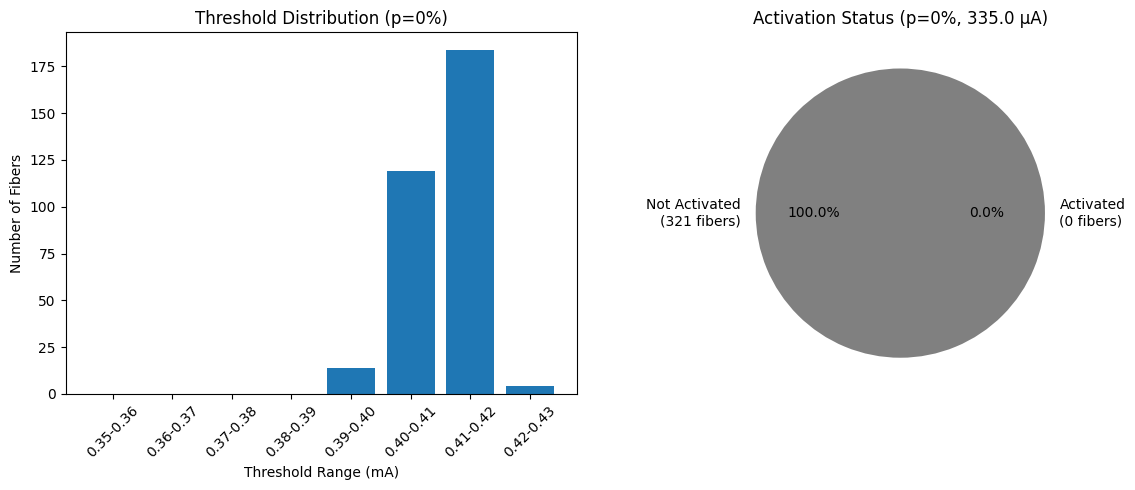

In [11]:
# Explore the 0% condition (400 μA total)
print_activation_details(0)


Detailed Fiber Activation Table for Condition: p=20%
Contact 1: 400 μA, Contact 2: 80.0 μA, Total: 402.0 μA (0.402 mA)
----------------------------------------------------------------------------------------------------
Sample of fiber activation data (first 10 fibers):


,fiber_index,inner,pos_x,pos_y,threshold_mA,is_activated
0,0,0,None,None,0.398652,True
1,1,0,None,None,0.404453,False
2,2,0,None,None,0.414121,False
3,3,0,None,None,0.398652,True
4,4,0,None,None,0.410254,False
5,5,0,None,None,0.410254,False
6,6,0,None,None,0.412187,False
7,7,0,None,None,0.416055,False
8,8,0,None,None,0.402520,False
9,9,0,None,None,0.410254,False




Activation Statistics by Inner Fascicle:


,Total Fibers,Activated Fibers,Activation %
inner,,,
0,321,25,7.788162




Activation Threshold Distribution:
  0.35 - 0.36 mA: 0 fibers
  0.36 - 0.37 mA: 0 fibers
  0.37 - 0.38 mA: 0 fibers
  0.38 - 0.39 mA: 0 fibers
  0.39 - 0.40 mA: 14 fibers
  0.40 - 0.41 mA: 119 fibers
  0.41 - 0.42 mA: 184 fibers
  0.42 - 0.43 mA: 4 fibers


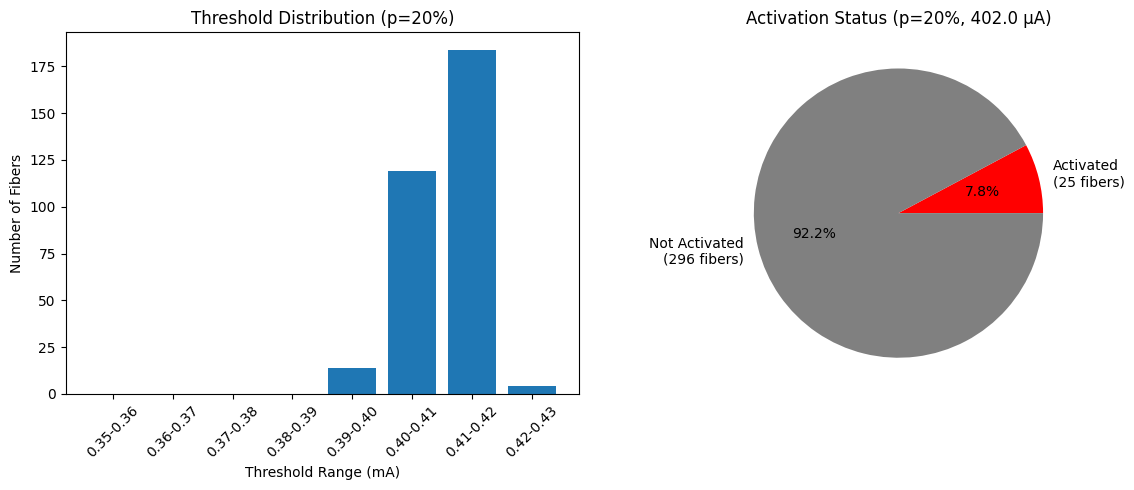

In [12]:
# Explore the 20% condition (480 μA total)
print_activation_details(20)


Detailed Fiber Activation Table for Condition: p=100%
Contact 1: 400 μA, Contact 2: 400.0 μA, Total: 670.0 μA (0.67 mA)
----------------------------------------------------------------------------------------------------
Sample of fiber activation data (first 10 fibers):


,fiber_index,inner,pos_x,pos_y,threshold_mA,is_activated
0,0,0,None,None,0.398652,True
1,1,0,None,None,0.404453,True
2,2,0,None,None,0.414121,True
3,3,0,None,None,0.398652,True
4,4,0,None,None,0.410254,True
5,5,0,None,None,0.410254,True
6,6,0,None,None,0.412187,True
7,7,0,None,None,0.416055,True
8,8,0,None,None,0.402520,True
9,9,0,None,None,0.410254,True




Activation Statistics by Inner Fascicle:


,Total Fibers,Activated Fibers,Activation %
inner,,,
0,321,321,100.0




Activation Threshold Distribution:
  0.35 - 0.36 mA: 0 fibers
  0.36 - 0.37 mA: 0 fibers
  0.37 - 0.38 mA: 0 fibers
  0.38 - 0.39 mA: 0 fibers
  0.39 - 0.40 mA: 14 fibers
  0.40 - 0.41 mA: 119 fibers
  0.41 - 0.42 mA: 184 fibers
  0.42 - 0.43 mA: 4 fibers


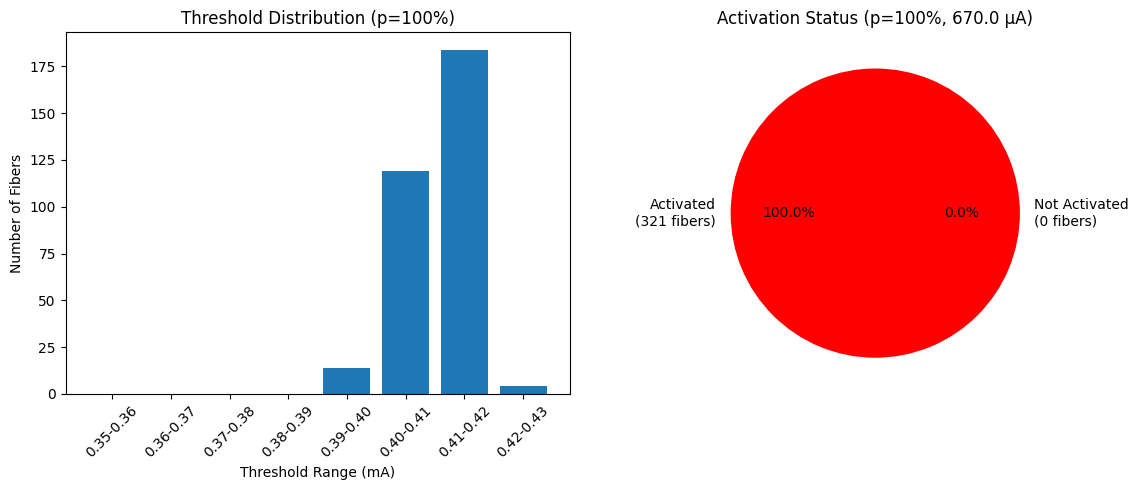

In [13]:
# Explore the 100% condition (800 μA total)
print_activation_details(100)

## Compare Conditions

Now let's create a function to compare activation statistics across conditions:

In [14]:
def compare_conditions():
    """
    Compare activation statistics across all conditions
    """
    # Collect activation percentages for each condition
    percentages = []
    total_currents = []
    activation_counts = []
    non_activation_counts = []
    p_values = []
    
    for p_percent in sorted(results.keys()):
        data = results[p_percent]
        df = data['activation_df']
        condition = data['condition']
        
        activated = df['is_activated'].sum()
        total = len(df)
        pct = 100.0 * activated / total
        
        percentages.append(pct)
        total_currents.append(condition['I_total_uA'])
        activation_counts.append(activated)
        non_activation_counts.append(total - activated)
        p_values.append(p_percent)
    
    # Create summary dataframe
    summary_df = pd.DataFrame({
        'p_percent': p_values,
        'Total Current (μA)': total_currents,
        'Activated Fibers': activation_counts,
        'Non-Activated Fibers': non_activation_counts,
        'Activation Percentage': percentages
    })
    
    # Display the summary table
    display(summary_df)
    
    # Create a comparison chart
    plt.figure(figsize=(12, 8))
    
    # Plot activation percentage vs total current
    plt.subplot(2, 1, 1)
    plt.plot(total_currents, percentages, 'o-', linewidth=2, markersize=10)
    for i, p in enumerate(p_values):
        plt.annotate(f"p={p}%", 
                    (total_currents[i], percentages[i]),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')
    plt.title('Activation Percentage vs Total Current')
    plt.xlabel('Total Current (μA)')
    plt.ylabel('Activation Percentage (%)')
    plt.grid(alpha=0.3)
    
    # Plot stacked bar chart of activated vs non-activated
    plt.subplot(2, 1, 2)
    width = 0.8
    p_labels = [f"{p}%" for p in p_values]
    plt.bar(p_labels, activation_counts, width, label='Activated', color='red')
    plt.bar(p_labels, non_activation_counts, width, bottom=activation_counts, label='Not Activated', color='grey')
    plt.title('Number of Activated and Non-Activated Fibers')
    plt.xlabel('Contact 2 Current Percentage')
    plt.ylabel('Number of Fibers')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return summary_df

,p_percent,Total Current (μA),Activated Fibers,Non-Activated Fibers,Activation Percentage
0,0,335.0,0,321,0.000000
1,20,402.0,25,296,7.788162
2,40,469.0,321,0,100.000000
3,60,536.0,321,0,100.000000
4,80,603.0,321,0,100.000000
5,100,670.0,321,0,100.000000


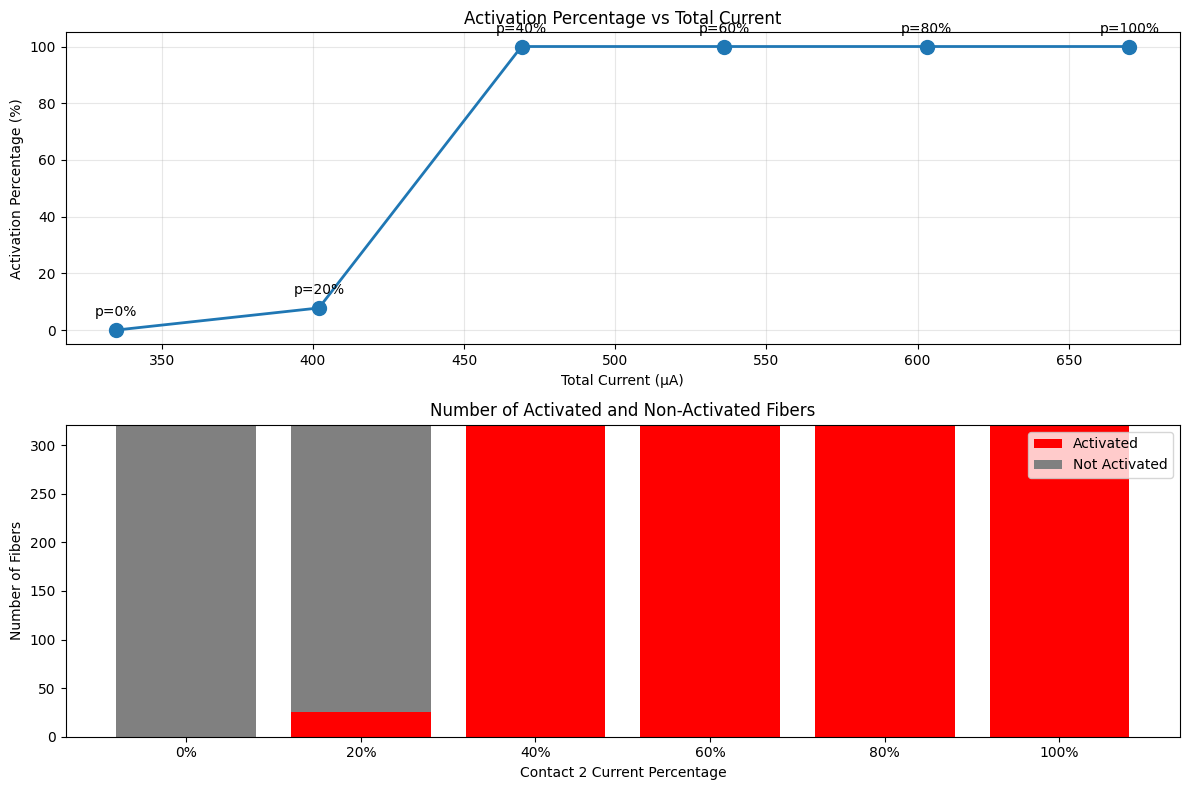

In [15]:
# Compare all conditions
summary_df = compare_conditions()

## Filter and Analyze Specific Fibers

Let's create a function to filter and analyze fibers based on specific criteria:

In [16]:
def filter_fibers(p_percent, min_threshold=None, max_threshold=None, activation_status=None):
    """
    Filter fibers based on threshold and activation status
    
    Parameters:
    p_percent (int): The percentage of Contact 2 current
    min_threshold (float): Minimum threshold (mA)
    max_threshold (float): Maximum threshold (mA)
    activation_status (bool): True for activated, False for non-activated, None for both
    
    Returns:
    pd.DataFrame: Filtered fiber data
    """
    if p_percent not in results:
        print(f"No data for p={p_percent}%")
        return None
    
    df = results[p_percent]['activation_df']
    filtered_df = df.copy()
    
    # Apply threshold filters
    if min_threshold is not None:
        filtered_df = filtered_df[filtered_df['threshold_mA'] >= min_threshold]
    
    if max_threshold is not None:
        filtered_df = filtered_df[filtered_df['threshold_mA'] <= max_threshold]
    
    # Apply activation status filter
    if activation_status is not None:
        filtered_df = filtered_df[filtered_df['is_activated'] == activation_status]
    
    print(f"Filtered results: {len(filtered_df)} fibers found matching criteria")
    
    return filtered_df

In [17]:
# Example: Find all fibers at p=0% with threshold between 0.395 and 0.405 mA
threshold_range_fibers = filter_fibers(p_percent=0, min_threshold=0.395, max_threshold=0.405)
display(threshold_range_fibers)

Filtered results: 87 fibers found matching criteria


,fiber_index,inner,pos_x,pos_y,threshold_mA,is_activated
0,0,0,None,None,0.398652,False
1,1,0,None,None,0.404453,False
3,3,0,None,None,0.398652,False
8,8,0,None,None,0.402520,False
16,16,0,None,None,0.398652,False
...,...,...,...,...,...,...
298,298,0,None,None,0.404453,False
304,304,0,None,None,0.402520,False
307,307,0,None,None,0.402520,False
309,309,0,None,None,0.398652,False


In [18]:
# Example: Find all activated fibers at p=0%
activated_fibers = filter_fibers(p_percent=0, activation_status=True)
display(activated_fibers)

Filtered results: 0 fibers found matching criteria


,fiber_index,inner,pos_x,pos_y,threshold_mA,is_activated


## Export Data to CSV and Excel for External Analysis

If you want to analyze the data in other tools, you can export it to CSV or Excel:

In [19]:
# Create directory for exports
export_dir = os.path.join('out', 'activation_profiles', 'exports')
os.makedirs(export_dir, exist_ok=True)

# Export individual condition data to CSV
for p_percent, data in results.items():
    # Export fiber data
    csv_path = os.path.join(export_dir, f'activation_data_p{p_percent}.csv')
    data['activation_df'].to_csv(csv_path, index=False)
    
    # Export inner stats if available
    if data['inner_stats'] is not None:
        stats_path = os.path.join(export_dir, f'inner_stats_p{p_percent}.csv')
        data['inner_stats'].to_csv(stats_path)

# Export all data to a single Excel file
excel_path = os.path.join(export_dir, 'all_activation_data.xlsx')
with pd.ExcelWriter(excel_path) as writer:
    # Save summary data
    summary_df.to_excel(writer, sheet_name='Summary', index=False)
    
    # Save individual condition data
    for p_percent, data in results.items():
        # Save fiber data
        data['activation_df'].to_excel(writer, sheet_name=f'Fibers_p{p_percent}', index=False)
        
        # Save inner stats if available
        if data['inner_stats'] is not None:
            data['inner_stats'].to_excel(writer, sheet_name=f'Stats_p{p_percent}')

print(f"Data exported to:\n- Individual CSVs in {export_dir}\n- Complete Excel file: {excel_path}")

Data exported to:
- Individual CSVs in out\activation_profiles\exports
- Complete Excel file: out\activation_profiles\exports\all_activation_data.xlsx


## Create Combined Visualization

Finally, let's create a combined visualization of all conditions:

Created animation: out\activation_profiles\activation_profiles_animation.gif


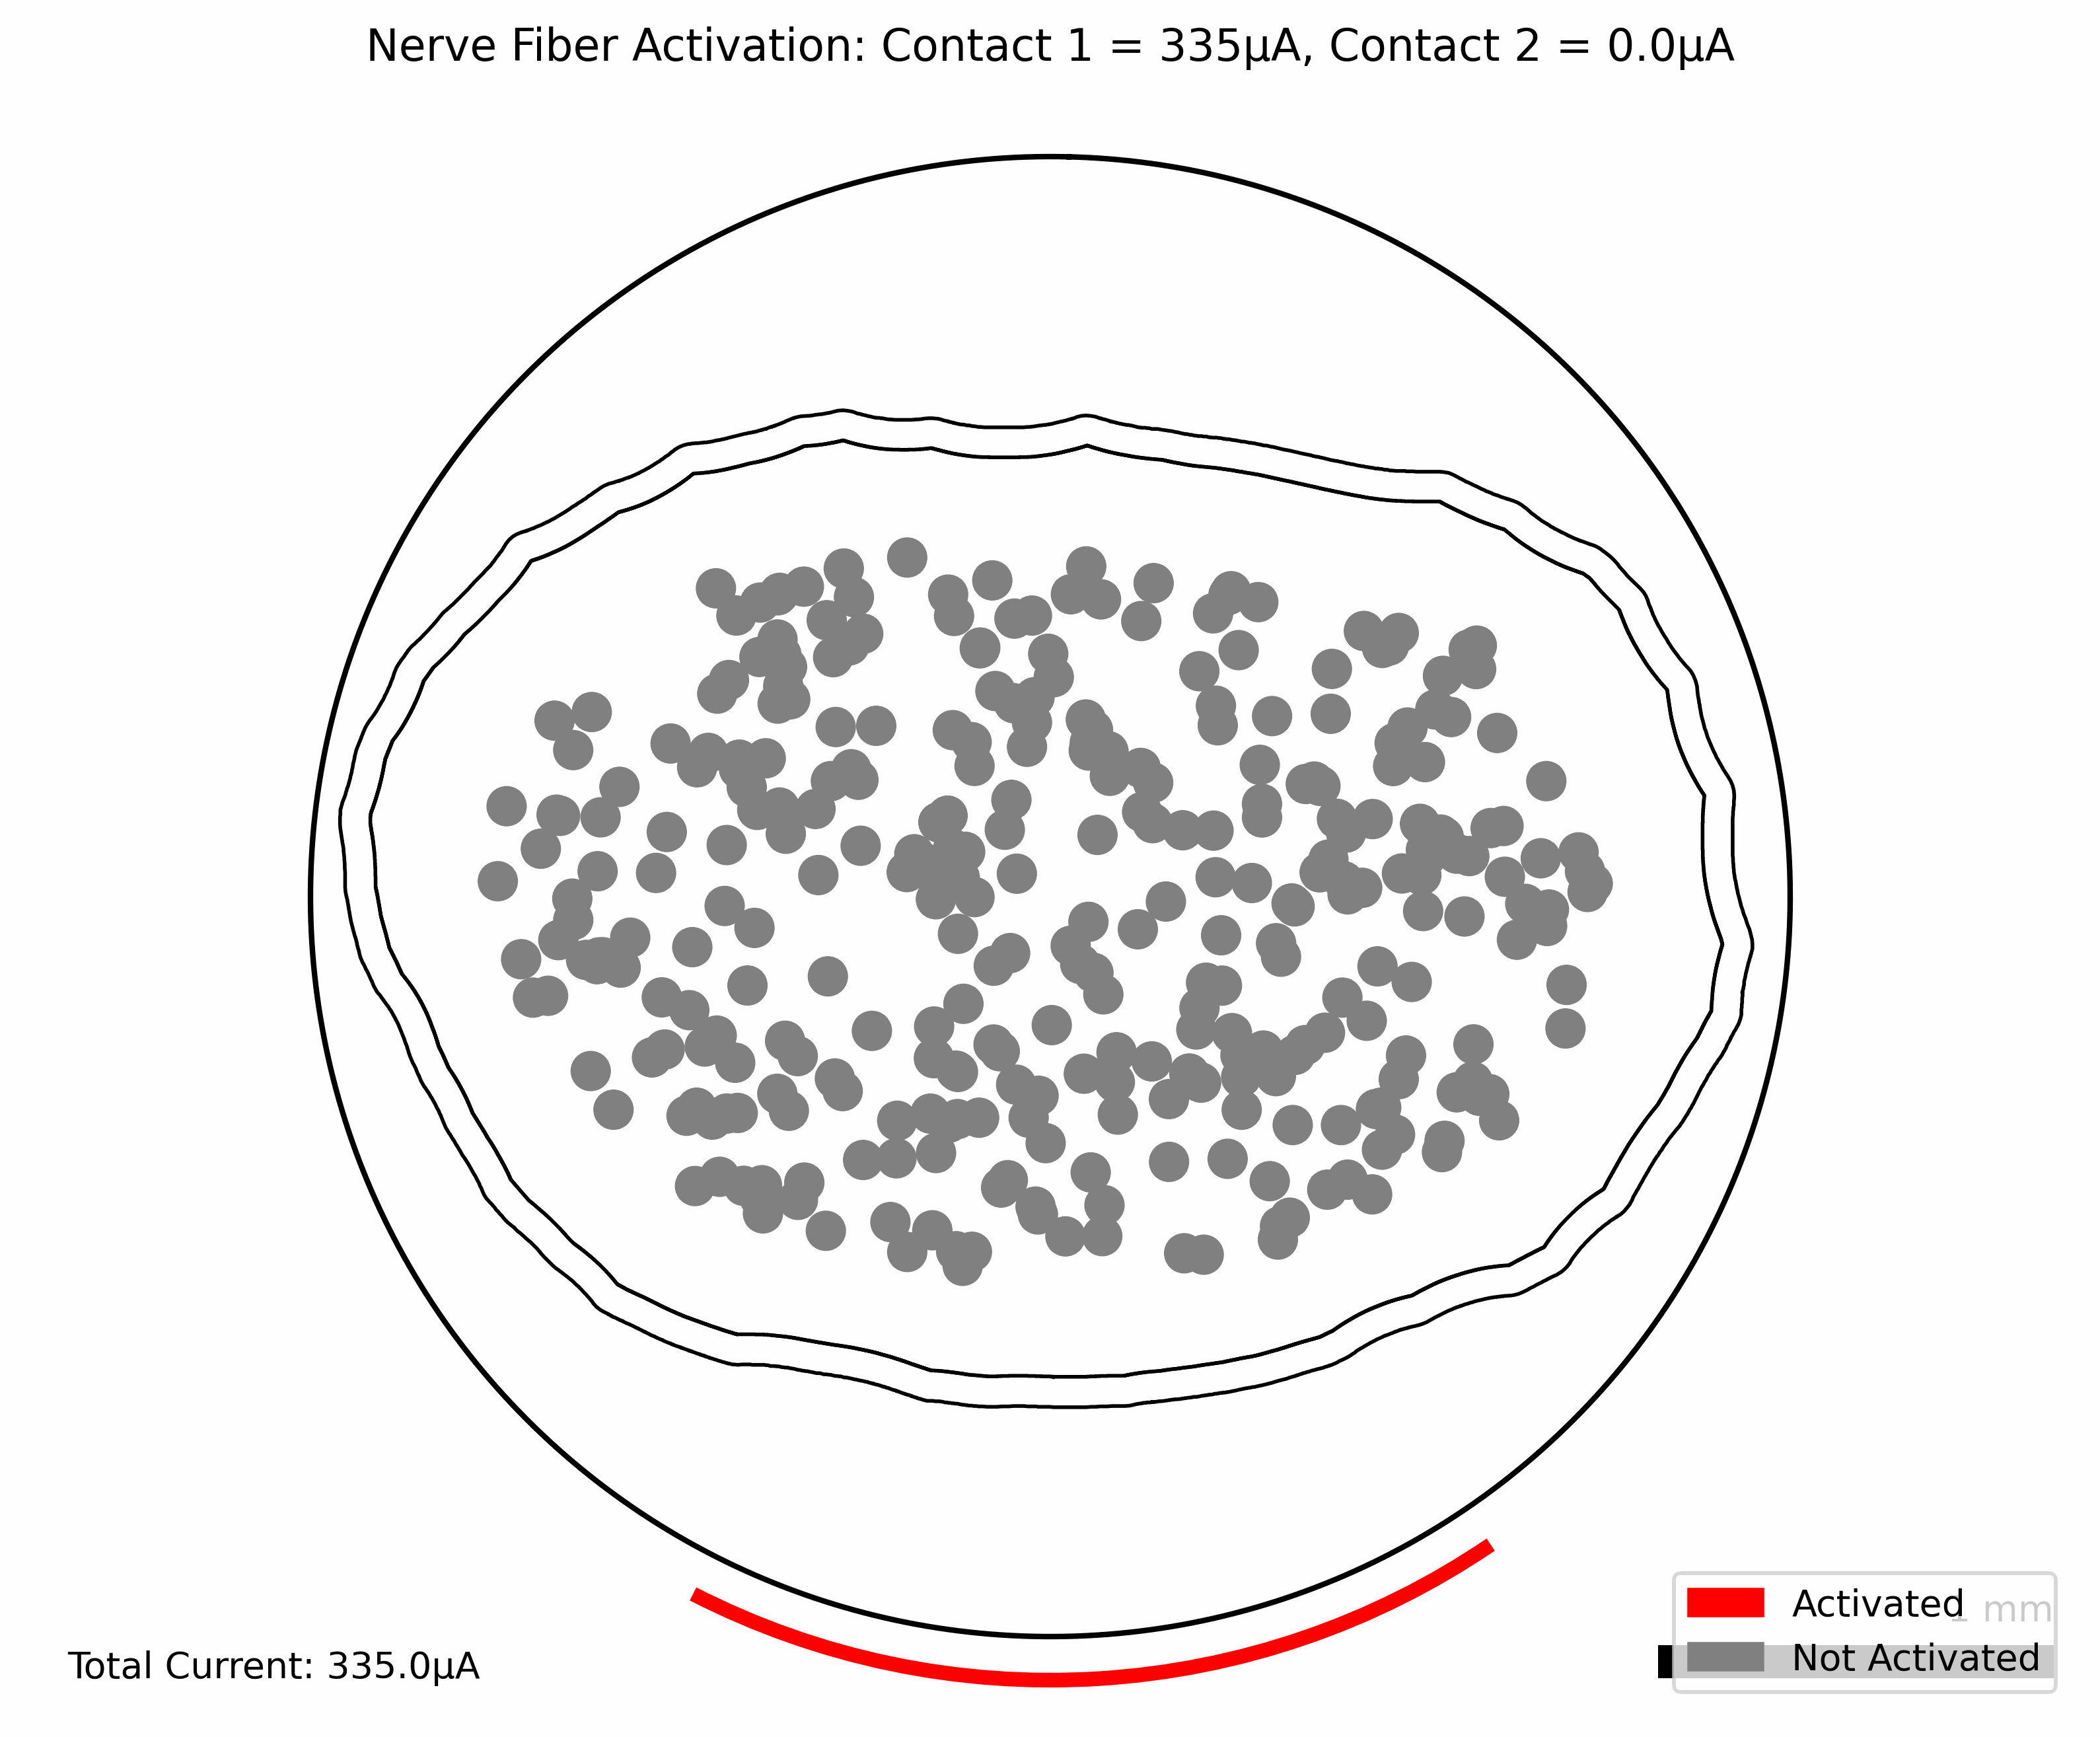

In [20]:
# Create animation from saved images
try:
    images = []
    for path in image_paths:
        images.append(imageio.v2.imread(path))  # Use v2 to avoid warning
    
    # Save as GIF with 1 frame per second
    output_gif = os.path.join(save_directory, 'activation_profiles_animation.gif')
    imageio.mimsave(output_gif, images, fps=1)
    print(f"Created animation: {output_gif}")
    
    # Display the animation in the notebook
    display(Image(filename=output_gif))
except Exception as e:
    print(f"Error creating animation: {e}")

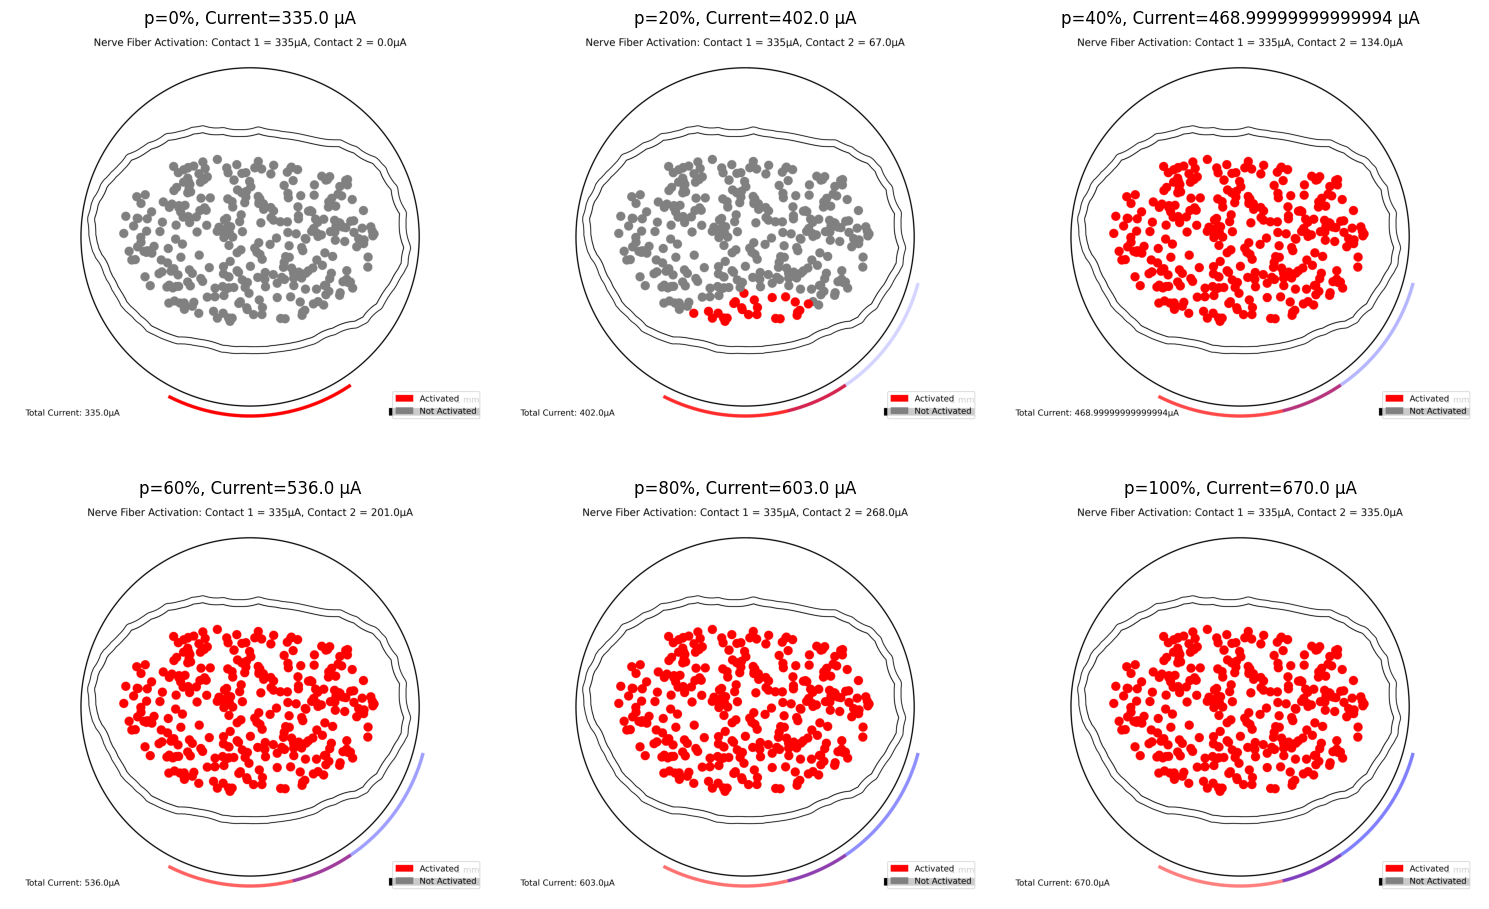

In [21]:
# Create a grid of all condition images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, p_percent in enumerate(sorted(results.keys())):
    img = plt.imread(image_paths[i])
    axes[i].imshow(img)
    axes[i].set_title(f'p={p_percent}%, Current={results[p_percent]["condition"]["I_total_uA"]} μA')
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(save_directory, 'activation_profiles_grid.png'), dpi=300)
plt.show()